In [1]:
!pip install timm

# Import libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter
import timm

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Set Seeds for Reproducibility

In [3]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [4]:
# Data transformations - Inception models use 299x299 input size
train_transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Inception models require 299x299
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

val_test_transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Inception models require 299x299
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

# Dataset

In [5]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, imaging_type_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths), tissue type (labels), and imaging type columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            imaging_type_encoder (LabelEncoder, optional): Pre-fitted imaging type encoder.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        # Handle imaging type encoding
        if imaging_type_encoder is None:
            self.imaging_type_encoder = LabelEncoder()
            if fit_label_encoder:
                self.imaging_types = self.imaging_type_encoder.fit_transform(self.data['imaging type'])
            else:
                raise ValueError("Must provide imaging_type_encoder or set fit_label_encoder=True")
        else:
            self.imaging_type_encoder = imaging_type_encoder
            self.imaging_types = self.imaging_type_encoder.transform(self.data['imaging type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        imaging_type = self.imaging_types[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long), torch.tensor(imaging_type, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_imaging_type_encoder(self):
        """Return the imaging type encoder for use with other datasets"""
        return self.imaging_type_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [6]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True  
    )
    
    # Get the fitted label encoder and imaging type encoder
    le = train_dataset.get_label_encoder()
    imaging_type_encoder = train_dataset.get_imaging_type_encoder()
    
    # Create validation dataset using the same label encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    # Create test dataset using the same label encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    return train_dataset, val_dataset, test_dataset, le, imaging_type_encoder

# Dataloader

In [7]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [8]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [9]:
train_dataset, val_dataset, test_dataset, label_encoder, imaging_type_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Utility Functions

In [10]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels, _ in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [11]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels, imaging_types in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    imaging_types = imaging_types.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs, imaging_types)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels, imaging_types in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                imaging_types = imaging_types.to(self.device)
                
                outputs = self.model(inputs, imaging_types)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

# Model Definitions

In [12]:
class InceptionWithImagingType(nn.Module):
    def __init__(self, base_model, num_features, num_classes=4, num_imaging_types=2, embedding_dim=16):
        super(InceptionWithImagingType, self).__init__()
        self.base_model = base_model
        
        # Imaging type embedding
        self.imaging_type_embedding = nn.Embedding(num_imaging_types, embedding_dim)
        
        # New classifier that takes both image features and imaging type
        self.classifier = nn.Linear(num_features + embedding_dim, num_classes)
        
    def forward(self, x, imaging_type):
        # Get image features
        image_features = self.base_model(x)
        
        # Get imaging type embedding
        imaging_embedding = self.imaging_type_embedding(imaging_type)
        
        # Concatenate features
        combined_features = torch.cat([image_features, imaging_embedding], dim=1)
        
        # Final classification
        output = self.classifier(combined_features)
        return output

def create_inception_v4_model(num_classes=4, num_imaging_types=2, pretrained=True):
    """Create Inception V4 model with imaging type input for bladder tissue classification (4 classes: HGC, LGC, NST, NTL)"""
    base_model = timm.create_model('inception_v4', pretrained=pretrained, num_classes=0)  # num_classes=0 removes classifier
    num_features = base_model.num_features  # Get feature dimension from model
    model = InceptionWithImagingType(base_model, num_features=num_features, num_classes=num_classes, num_imaging_types=num_imaging_types)
    return model

def create_inception_resnet_v2_model(num_classes=4, num_imaging_types=2, pretrained=True):
    """Create Inception ResNet V2 model with imaging type input for bladder tissue classification (4 classes: HGC, LGC, NST, NTL)"""
    base_model = timm.create_model('inception_resnet_v2', pretrained=pretrained, num_classes=0)  # num_classes=0 removes classifier
    num_features = base_model.num_features  # Get feature dimension from model
    model = InceptionWithImagingType(base_model, num_features=num_features, num_classes=num_classes, num_imaging_types=num_imaging_types)
    return model
        

# Configure GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [14]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [15]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train Inception V4

Training Inception V4 with Imaging Type


model.safetensors:   0%|          | 0.00/171M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=0.7538, Acc=0.7336]


Train Loss: 0.7538 Acc: 0.7336 Macro-F1: 0.6807


Val : 100%|██████████| 10/10 [00:02<00:00,  4.65it/s, Loss=1.5361, Acc=0.4704]


Val Loss: 1.5361 Acc: 0.4704 Macro-F1: 0.4461
✓ New best model saved with validation macro-F1: 0.4461

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.74it/s, Loss=0.2650, Acc=0.9112]


Train Loss: 0.2650 Acc: 0.9112 Macro-F1: 0.8908


Val : 100%|██████████| 10/10 [00:01<00:00,  5.23it/s, Loss=0.6386, Acc=0.8059]


Val Loss: 0.6386 Acc: 0.8059 Macro-F1: 0.7825
✓ New best model saved with validation macro-F1: 0.7825

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.74it/s, Loss=0.3026, Acc=0.9021]


Train Loss: 0.3026 Acc: 0.9021 Macro-F1: 0.8634


Val : 100%|██████████| 10/10 [00:01<00:00,  5.27it/s, Loss=0.3319, Acc=0.8947]


Val Loss: 0.3319 Acc: 0.8947 Macro-F1: 0.8579
✓ New best model saved with validation macro-F1: 0.8579

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.74it/s, Loss=0.1417, Acc=0.9597]


Train Loss: 0.1417 Acc: 0.9597 Macro-F1: 0.9504


Val : 100%|██████████| 10/10 [00:01<00:00,  5.35it/s, Loss=0.0891, Acc=0.9704]


Val Loss: 0.0891 Acc: 0.9704 Macro-F1: 0.9498
✓ New best model saved with validation macro-F1: 0.9498

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.74it/s, Loss=0.1362, Acc=0.9572]


Train Loss: 0.1362 Acc: 0.9572 Macro-F1: 0.9499


Val : 100%|██████████| 10/10 [00:01<00:00,  5.22it/s, Loss=1.0472, Acc=0.6546]


Val Loss: 1.0472 Acc: 0.6546 Macro-F1: 0.6418

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.74it/s, Loss=0.2321, Acc=0.9309]


Train Loss: 0.2321 Acc: 0.9309 Macro-F1: 0.9076


Val : 100%|██████████| 10/10 [00:01<00:00,  5.08it/s, Loss=1.6477, Acc=0.4868]


Val Loss: 1.6477 Acc: 0.4868 Macro-F1: 0.3891

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.74it/s, Loss=0.2137, Acc=0.9326]


Train Loss: 0.2137 Acc: 0.9326 Macro-F1: 0.9141


Val : 100%|██████████| 10/10 [00:01<00:00,  5.26it/s, Loss=0.1420, Acc=0.9605]


Val Loss: 0.1420 Acc: 0.9605 Macro-F1: 0.9475

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.74it/s, Loss=0.1142, Acc=0.9630]


Train Loss: 0.1142 Acc: 0.9630 Macro-F1: 0.9557


Val : 100%|██████████| 10/10 [00:01<00:00,  5.21it/s, Loss=0.0458, Acc=0.9836]


Val Loss: 0.0458 Acc: 0.9836 Macro-F1: 0.9731
✓ New best model saved with validation macro-F1: 0.9731

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.73it/s, Loss=0.0590, Acc=0.9836]


Train Loss: 0.0590 Acc: 0.9836 Macro-F1: 0.9793


Val : 100%|██████████| 10/10 [00:01<00:00,  5.25it/s, Loss=0.0366, Acc=0.9836]


Val Loss: 0.0366 Acc: 0.9836 Macro-F1: 0.9784
✓ New best model saved with validation macro-F1: 0.9784

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.73it/s, Loss=0.0304, Acc=0.9959]


Train Loss: 0.0304 Acc: 0.9959 Macro-F1: 0.9967


Val : 100%|██████████| 10/10 [00:01<00:00,  5.26it/s, Loss=0.0355, Acc=0.9901]


Val Loss: 0.0355 Acc: 0.9901 Macro-F1: 0.9836
✓ New best model saved with validation macro-F1: 0.9836

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.74it/s, Loss=0.0232, Acc=0.9926]


Train Loss: 0.0232 Acc: 0.9926 Macro-F1: 0.9931


Val : 100%|██████████| 10/10 [00:01<00:00,  5.17it/s, Loss=0.0382, Acc=0.9836]


Val Loss: 0.0382 Acc: 0.9836 Macro-F1: 0.9784

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.74it/s, Loss=0.0229, Acc=0.9934]


Train Loss: 0.0229 Acc: 0.9934 Macro-F1: 0.9937


Val : 100%|██████████| 10/10 [00:01<00:00,  5.22it/s, Loss=0.0281, Acc=0.9901]


Val Loss: 0.0281 Acc: 0.9901 Macro-F1: 0.9878
✓ New best model saved with validation macro-F1: 0.9878

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.74it/s, Loss=0.0149, Acc=0.9992]


Train Loss: 0.0149 Acc: 0.9992 Macro-F1: 0.9993


Val : 100%|██████████| 10/10 [00:01<00:00,  5.29it/s, Loss=0.0216, Acc=0.9868]


Val Loss: 0.0216 Acc: 0.9868 Macro-F1: 0.9805

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.74it/s, Loss=0.0153, Acc=0.9967]


Train Loss: 0.0153 Acc: 0.9967 Macro-F1: 0.9962


Val : 100%|██████████| 10/10 [00:01<00:00,  5.25it/s, Loss=0.0205, Acc=0.9901]


Val Loss: 0.0205 Acc: 0.9901 Macro-F1: 0.9831

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.74it/s, Loss=0.0110, Acc=0.9967]


Train Loss: 0.0110 Acc: 0.9967 Macro-F1: 0.9963


Val : 100%|██████████| 10/10 [00:01<00:00,  5.20it/s, Loss=0.0212, Acc=0.9901]


Val Loss: 0.0212 Acc: 0.9901 Macro-F1: 0.9831

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.74it/s, Loss=0.0111, Acc=0.9967]


Train Loss: 0.0111 Acc: 0.9967 Macro-F1: 0.9973


Val : 100%|██████████| 10/10 [00:02<00:00,  4.96it/s, Loss=0.0208, Acc=0.9901]


Val Loss: 0.0208 Acc: 0.9901 Macro-F1: 0.9831

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.74it/s, Loss=0.0092, Acc=1.0000]


Train Loss: 0.0092 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  5.23it/s, Loss=0.0192, Acc=0.9901]


Val Loss: 0.0192 Acc: 0.9901 Macro-F1: 0.9831
Early stopping triggered after 17 epochs
Training complete in 6m 50s
Best validation macro-F1: 0.9878


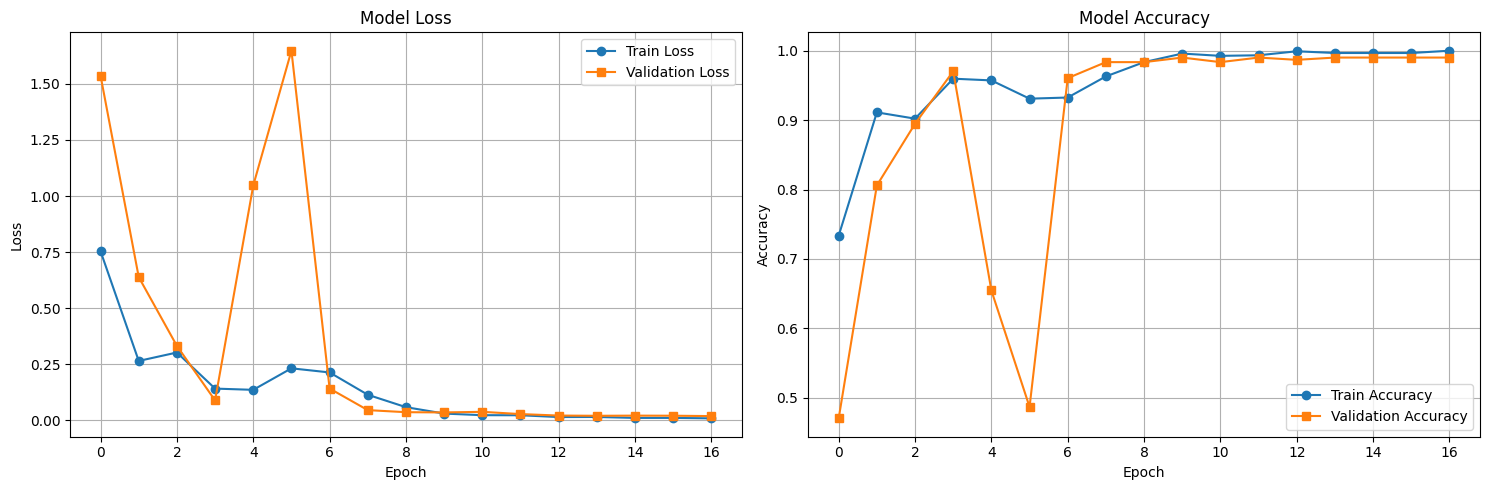

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  3.99it/s]


Test Accuracy: 47.62%
Test Loss: 2.1908

Classification Report:
              precision    recall  f1-score   support

         HGC       0.48      0.46      0.47        74
         LGC       0.35      0.17      0.23        53
         NST       0.57      0.68      0.62        37
         NTL       0.46      0.88      0.60        25

    accuracy                           0.48       189
   macro avg       0.46      0.55      0.48       189
weighted avg       0.46      0.48      0.45       189


Confusion Matrix:
[[34 16 10 14]
 [35  9  6  3]
 [ 2  1 25  9]
 [ 0  0  3 22]]

ROC-AUC Scores:
Macro-average AUC: 0.7286
Micro-average AUC: 0.7115
HGC AUC: 0.6344
LGC AUC: 0.5216
NST AUC: 0.8188
NTL AUC: 0.9395


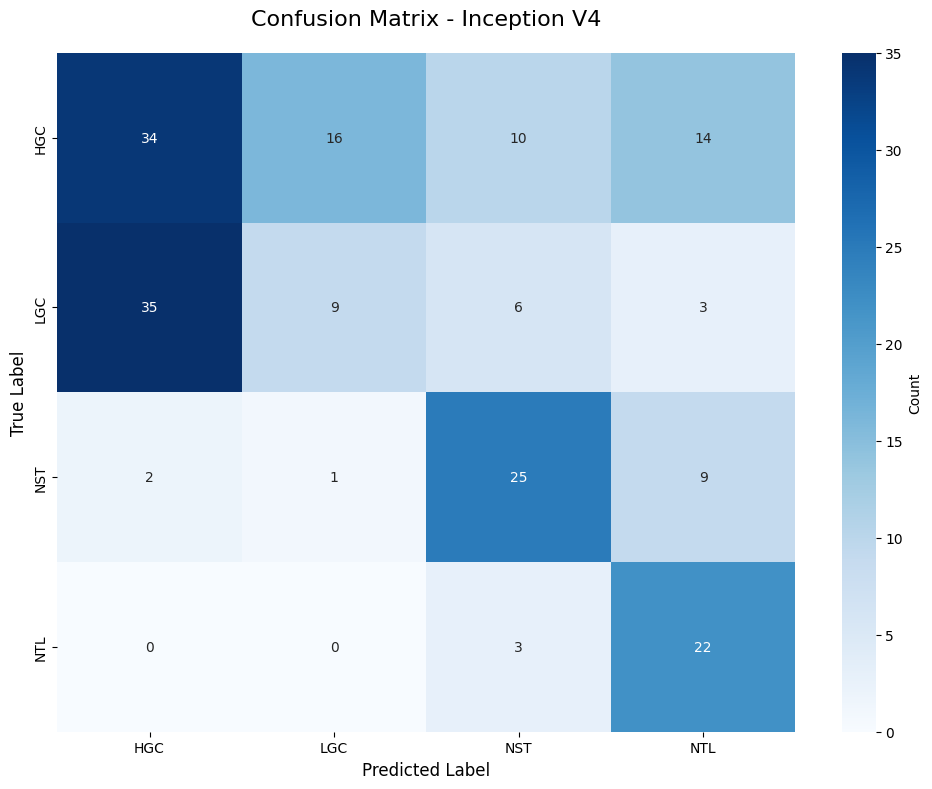

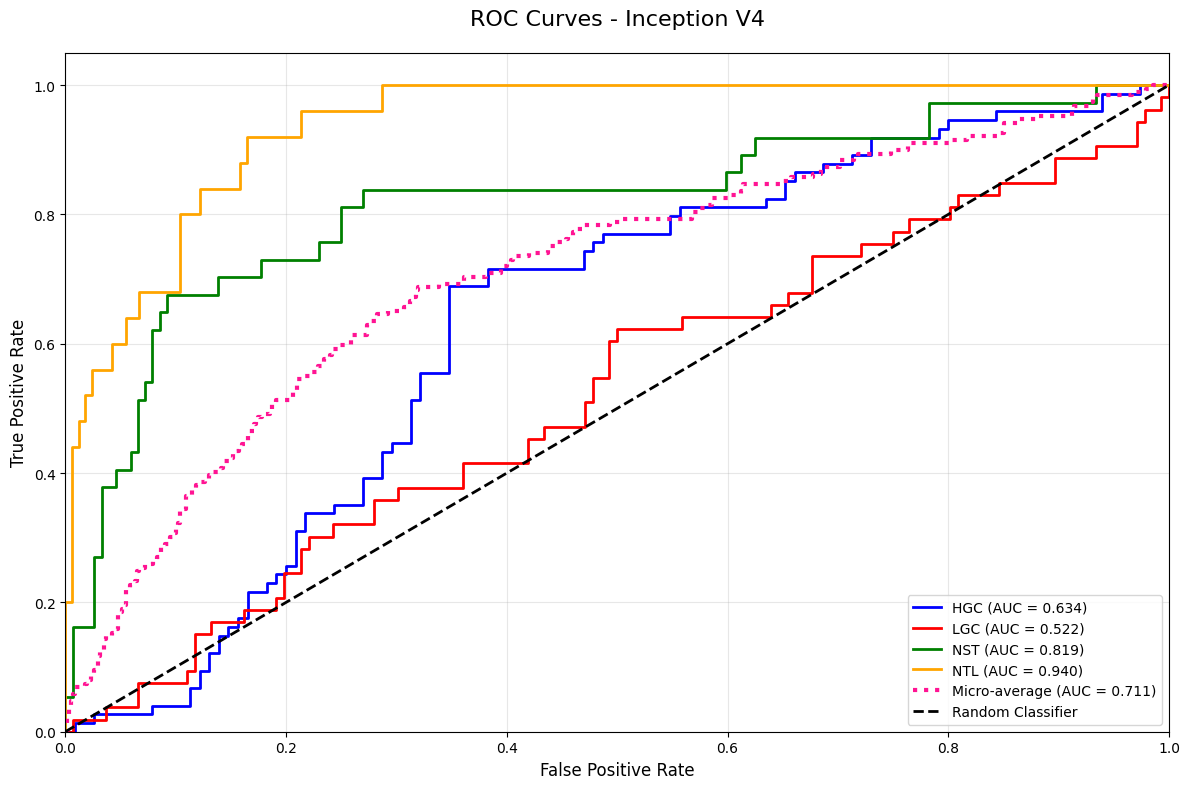


Inception V4 training and evaluation complete!


In [16]:
print("=" * 80)
print("Training Inception V4 with Imaging Type")
print("=" * 80)

# Create model
inception_v4 = create_inception_v4_model(num_classes=4, num_imaging_types=2, pretrained=True)

# Create trainer
trainer_v4 = ModelTrainer(inception_v4, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_v4 = trainer_v4.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="inception_v4_with_ImagingType")

# Plot training history
trainer_v4.plot_training_history(save_path='inception_v4_training_history.png')

# Evaluate model
results_v4 = trainer_v4.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_v4['confusion_matrix'], class_names, 'Inception V4',
                      save_path='inception_v4_confusion_matrix.png')

# Plot ROC curves
roc_auc_v4 = plot_roc_curves(results_v4['labels'], results_v4['probabilities'], class_names, 'Inception V4',
                              save_path='inception_v4_roc_curves.png')
# Store results
results_v4['model_name'] = 'Inception V4'
results_v4['roc_auc'] = roc_auc_v4
all_results.append(results_v4)

print("\nInception V4 training and evaluation complete!")

## Train Inception ResNet V2

Training Inception ResNet V2 with Imaging Type


model.safetensors:   0%|          | 0.00/224M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.59it/s, Loss=0.7258, Acc=0.7163]


Train Loss: 0.7258 Acc: 0.7163 Macro-F1: 0.6658


Val : 100%|██████████| 10/10 [00:02<00:00,  4.25it/s, Loss=0.2622, Acc=0.9276]


Val Loss: 0.2622 Acc: 0.9276 Macro-F1: 0.8733
✓ New best model saved with validation macro-F1: 0.8733

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.59it/s, Loss=0.2791, Acc=0.9153]


Train Loss: 0.2791 Acc: 0.9153 Macro-F1: 0.8837


Val : 100%|██████████| 10/10 [00:02<00:00,  4.52it/s, Loss=1.9322, Acc=0.7171]


Val Loss: 1.9322 Acc: 0.7171 Macro-F1: 0.6852

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=0.1313, Acc=0.9605]


Train Loss: 0.1313 Acc: 0.9605 Macro-F1: 0.9422


Val : 100%|██████████| 10/10 [00:02<00:00,  4.56it/s, Loss=0.1739, Acc=0.9507]


Val Loss: 0.1739 Acc: 0.9507 Macro-F1: 0.9316
✓ New best model saved with validation macro-F1: 0.9316

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=0.0476, Acc=0.9844]


Train Loss: 0.0476 Acc: 0.9844 Macro-F1: 0.9855


Val : 100%|██████████| 10/10 [00:02<00:00,  4.43it/s, Loss=0.1713, Acc=0.9539]


Val Loss: 0.1713 Acc: 0.9539 Macro-F1: 0.9340
✓ New best model saved with validation macro-F1: 0.9340

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.58it/s, Loss=0.0174, Acc=0.9951]


Train Loss: 0.0174 Acc: 0.9951 Macro-F1: 0.9961


Val : 100%|██████████| 10/10 [00:02<00:00,  4.46it/s, Loss=0.0139, Acc=1.0000]


Val Loss: 0.0139 Acc: 1.0000 Macro-F1: 1.0000
✓ New best model saved with validation macro-F1: 1.0000

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=0.0154, Acc=0.9959]


Train Loss: 0.0154 Acc: 0.9959 Macro-F1: 0.9935


Val : 100%|██████████| 10/10 [00:02<00:00,  4.44it/s, Loss=0.3931, Acc=0.9243]


Val Loss: 0.3931 Acc: 0.9243 Macro-F1: 0.8911

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=0.1262, Acc=0.9605]


Train Loss: 0.1262 Acc: 0.9605 Macro-F1: 0.9436


Val : 100%|██████████| 10/10 [00:02<00:00,  4.49it/s, Loss=0.2564, Acc=0.8947]


Val Loss: 0.2564 Acc: 0.8947 Macro-F1: 0.8526

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=0.0447, Acc=0.9868]


Train Loss: 0.0447 Acc: 0.9868 Macro-F1: 0.9847


Val : 100%|██████████| 10/10 [00:02<00:00,  4.53it/s, Loss=0.0302, Acc=0.9901]


Val Loss: 0.0302 Acc: 0.9901 Macro-F1: 0.9878

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=0.0194, Acc=0.9926]


Train Loss: 0.0194 Acc: 0.9926 Macro-F1: 0.9942


Val : 100%|██████████| 10/10 [00:02<00:00,  4.49it/s, Loss=0.0215, Acc=0.9934]


Val Loss: 0.0215 Acc: 0.9934 Macro-F1: 0.9903

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=0.0124, Acc=0.9984]


Train Loss: 0.0124 Acc: 0.9984 Macro-F1: 0.9976


Val : 100%|██████████| 10/10 [00:02<00:00,  4.48it/s, Loss=0.0204, Acc=0.9934]


Val Loss: 0.0204 Acc: 0.9934 Macro-F1: 0.9903
Early stopping triggered after 10 epochs
Training complete in 4m 23s
Best validation macro-F1: 1.0000


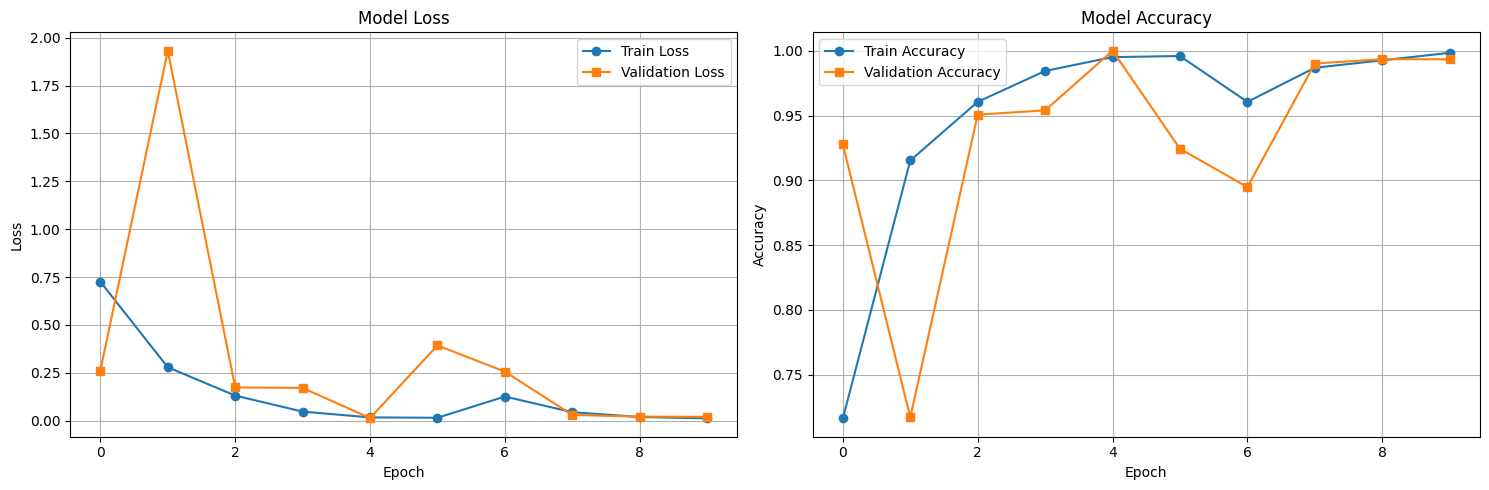

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  3.66it/s]


Test Accuracy: 46.03%
Test Loss: 1.7269

Classification Report:
              precision    recall  f1-score   support

         HGC       0.39      0.27      0.32        74
         LGC       0.32      0.36      0.34        53
         NST       0.67      0.70      0.68        37
         NTL       0.55      0.88      0.68        25

    accuracy                           0.46       189
   macro avg       0.48      0.55      0.51       189
weighted avg       0.45      0.46      0.44       189


Confusion Matrix:
[[20 39  7  8]
 [30 19  3  1]
 [ 1  1 26  9]
 [ 0  0  3 22]]

ROC-AUC Scores:
Macro-average AUC: 0.7572
Micro-average AUC: 0.7445
HGC AUC: 0.6127
LGC AUC: 0.5799
NST AUC: 0.9109
NTL AUC: 0.9251


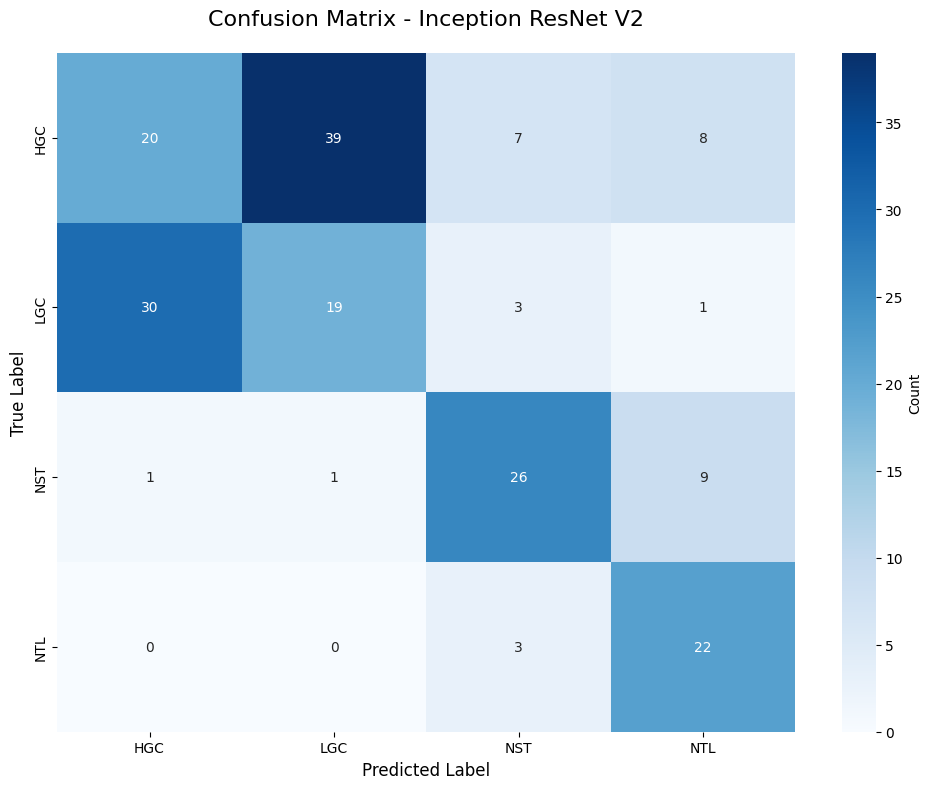

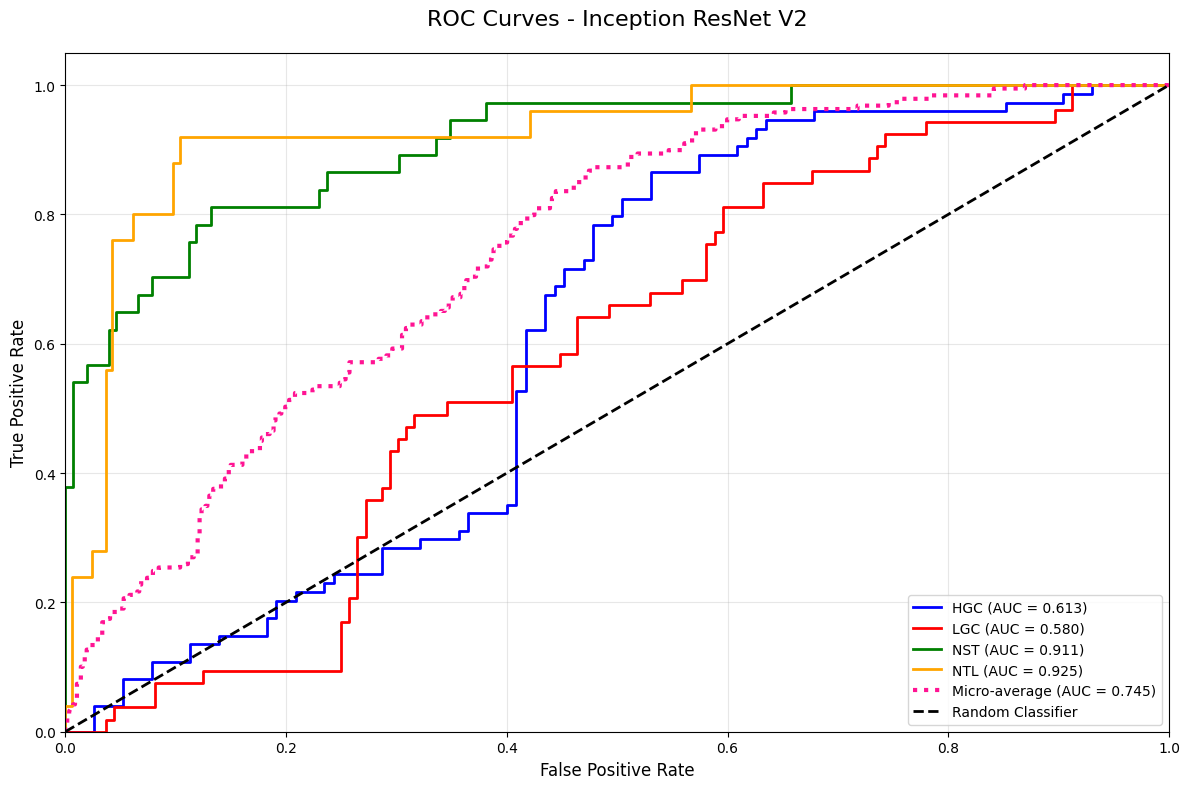


Inception ResNet V2 training and evaluation complete!


In [17]:
print("=" * 80)
print("Training Inception ResNet V2 with Imaging Type")
print("=" * 80)

# Create model
inception_resnet_v2 = create_inception_resnet_v2_model(num_classes=4, num_imaging_types=2, pretrained=True)

# Create trainer
trainer_resnet_v2 = ModelTrainer(inception_resnet_v2, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_resnet_v2 = trainer_resnet_v2.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="inception_resnet_v2_with_ImagingType")

# Plot training history
trainer_resnet_v2.plot_training_history(save_path='inception_resnet_v2_training_history.png')

# Evaluate model
results_resnet_v2 = trainer_resnet_v2.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_resnet_v2['confusion_matrix'], class_names, 'Inception ResNet V2',
                      save_path='inception_resnet_v2_confusion_matrix.png')

# Plot ROC curves
roc_auc_resnet_v2 = plot_roc_curves(results_resnet_v2['labels'], results_resnet_v2['probabilities'], class_names, 'Inception ResNet V2',
                                     save_path='inception_resnet_v2_roc_curves.png')
# Store results
results_resnet_v2['model_name'] = 'Inception ResNet V2'
results_resnet_v2['roc_auc'] = roc_auc_resnet_v2
all_results.append(results_resnet_v2)

print("\nInception ResNet V2 training and evaluation complete!")

# Save All Metrics to CSV

In [18]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'Inception_V4_ResNetV2_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())



Metrics saved to: Inception_V4_ResNetV2_metrics.csv

Metrics Summary:
                 Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0         Inception V4         47.619048      2.190843             0.462886          0.546237      0.479209                0.456422             0.476190         0.448081       0.478873    0.459459  0.468966         74.0       0.346154    0.169811  0.227848         53.0       0.568182    0.675676  0.617284         37.0       0.458333        0.88  0.602740         25.0   0.728599   0.711477  0.634430  0.521643  0.818812